# Оценка влияния времени работы машиниста на возникновение грубых нарушений безопасности движения и построение модели прогнозирования факта совершения нарушения в ближайшие 30 дней

## 1. Загрузка библиотек

In [1]:
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plot_helper
import scipy
import datetime
from tqdm.notebook import tqdm
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

## 2. Загрузка данных

In [2]:
data = pd.read_csv("data_for_student/crews_trips_1088292703.csv")

In [3]:
data.head()

,Unnamed: 0,year,month,day,road,depo,column,crew,age,experience_prof,...,DATE,IS_GRUB_7,VIOL_VES_SUM_7,VINA_MASH_SUM_7,IS_GRUB_14,VIOL_VES_SUM_14,VINA_MASH_SUM_14,IS_GRUB_30,VIOL_VES_SUM_30,VINA_MASH_SUM_30
0,66280,2021,1,1,1088292703,3527273890,31611311,61187200,52,2364,...,2021-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66281,2021,1,2,1088292703,3527273890,31611311,61187200,52,2364,...,2021-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66282,2021,1,3,1088292703,3527273890,31611311,61187200,52,2364,...,2021-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66283,2021,1,4,1088292703,3527273890,31611311,61187200,52,2364,...,2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,66284,2021,1,5,1088292703,3527273890,31611311,61187200,52,2364,...,2021-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data.shape

(170598, 148)

## 3. Подготовка данных

In [10]:
data = data.sort_values(by=["year", "month", "day"])
data.index = range(data.shape[0])
data["date_work"] = data.apply(lambda x: datetime.datetime(year=x.year, month=x.month, day=x.day), axis=1)

### 3.1. Очистка данных

In [11]:
# удаление столбца с не нужными индексами
data.drop("Unnamed: 0", axis=1, inplace=True)

In [12]:
data.head()

,year,month,day,road,depo,column,crew,age,experience_prof,experience_company,...,IS_GRUB_7,VIOL_VES_SUM_7,VINA_MASH_SUM_7,IS_GRUB_14,VIOL_VES_SUM_14,VINA_MASH_SUM_14,IS_GRUB_30,VIOL_VES_SUM_30,VINA_MASH_SUM_30,date_work
0,2021,1,1,1088292703,3527273890,31611311,61187200,52,2364,11876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01
1,2021,1,1,1088292703,3527273890,3161137,61183410,47,151,5535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01
2,2021,1,1,1088292703,3527273890,3161136,61187171,36,2364,5599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01
3,2021,1,1,1088292703,3527273890,3161136,61196976,33,1641,3499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01
4,2021,1,1,1088292703,3527273890,31611314,61182605,40,185,6433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01


In [13]:
# определение количества пропуска в данных
print("Количество ячеек со значением NAN/NULL - ", data.isnull().sum().sum())

Количество ячеек со значением NAN/NULL -  2110537


In [14]:
# определение колонок с пустими значениями
cols_is_null = data.isnull().sum()
cols_is_null = cols_is_null[cols_is_null != 0]
cols_is_null

VIOL_DATE               162349
DATE_YAVK               162349
VINA_MASH               162349
VIOL_CODE               162349
REASON                  162349
VIOL_EVENTS             162349
VIOL_EVENTS_POM_MASH    162349
ID_VIOL                 162349
VIOL_GUILT              162349
VIOL_VES                162349
VINA_MASH_SUM           162349
VIOL_VES_SUM            162349
IS_GRUB                 162349
dtype: int64

In [15]:
# определяем значения для VIOL_DATE, которыми будем заполнять NULL/NAN
data[~data.VIOL_DATE.isnull()].VIOL_DATE.head()

17                    [Timestamp('2021-01-01 00:00:00')]
123                   [Timestamp('2021-01-01 22:18:00')]
139                   [Timestamp('2021-01-01 00:00:00')]
148                   [Timestamp('2021-01-02 15:32:00')]
186    [Timestamp('2021-01-02 03:24:00'), Timestamp('...
Name: VIOL_DATE, dtype: object

In [16]:
data.VIOL_DATE.fillna("[]", inplace=True)

In [17]:
# определяем значения для IS_GRUB, которыми будем заполнять NULL/NAN
data[~data.IS_GRUB.isnull()].IS_GRUB.value_counts()

IS_GRUB
0.0    7901
1.0     348
Name: count, dtype: int64

In [18]:
data.IS_GRUB.fillna(0, inplace=True)

аналогичную процедру с удалением делаем и с другими колонками, которые планируем использовать для обучения

In [19]:
# определение колонок с пустыми значениями
cols_is_null = data.isnull().sum()
cols_is_null = cols_is_null[cols_is_null != 0]
cols_is_null

DATE_YAVK               162349
VINA_MASH               162349
VIOL_CODE               162349
REASON                  162349
VIOL_EVENTS             162349
VIOL_EVENTS_POM_MASH    162349
ID_VIOL                 162349
VIOL_GUILT              162349
VIOL_VES                162349
VINA_MASH_SUM           162349
VIOL_VES_SUM            162349
dtype: int64

### 3.2. Определение перечня признаков

In [21]:
cat_features = """month, depo, column, psich_pfo_group, group_risk, group_prevention, loco_ser"""

num_features = """
age, experience_prof, experience_company, 
count_trip_180, count_trip_90, count_trip_30, count_trip_7, 
time_work_180, time_work_90, time_work_30, time_work_7, 
prmo_end, prmo_fail_90, prmo_fail_30, prmo_fail_10, 
prmo_warn_90, prmo_warn_30, prmo_warn_10, 
prmo_replay_90, prmo_replay_30, prmo_replay_10, 
prmo_adapt_warn_90, prmo_adapt_warn_30, prmo_adapt_warn_10, 
prmo_adapt_fail_90, prmo_adapt_fail_30, prmo_adapt_fail_10, 
unique_pom_180, unique_pom_90, unique_pom_30, unique_pom_10, 
trips_no_pom_30, trips_no_pom_10, pom_tab_num, 
ndb_hard_365, ndb_hard_180, ndb_hard_90, ndb_hard_30, ndb_hard_10, 
ndb_easy_365, ndb_easy_180, ndb_easy_90, ndb_easy_30, ndb_easy_10, 
ndb_weight_365, ndb_weight_180, ndb_weight_90, ndb_weight_30, ndb_weight_10, 
ndb_hard_novina, ndb_easy_novina, ndb_weight_novina, 
viol_cpr_365, viol_cpr_180, viol_cpr_90, viol_cpr_30, viol_cpr_10, 
viol_cpr_weight_365, viol_cpr_weight_180, viol_cpr_weight_90, viol_cpr_weight_30, viol_cpr_weight_10, 
aspt_tu_count, aspt_tu_avg, aspt_tu_fail, aspt_tu_1, aspt_tu_2, aspt_tu_3, aspt_tu_4, 
aspt_no_planes_count, aspt_no_planes_fail, aspt_no_planes_avg, aspt_class, aspt_period, 
asu_zm_180, asu_zm_90, asu_zm_30, asu_zm_10, 
asu_zm_weight_180, asu_zm_weight_90, asu_zm_weight_30, asu_zm_weight_10, 
dkfs_count_365, dkfs_count_180, 
dkfs_count_fail_365, dkfs_count_fail_180, dkfs_count_fail_90, dkfs_count_fail_30, dkfs_count_fail_10, 
factor_knowledge, factor_experience, factor_Inattention, factor_distraction, factor_rush
"""

f_cat = cat_features.replace("\n", "").split(", ")
f_num = num_features.replace("\n", "").split(", ")

In [22]:
data.head()[f_cat]

,age,experience_prof,experience_company,count_trip_180,count_trip_90,count_trip_30,count_trip_7,time_work_180,time_work_90,time_work_30,...,dkfs_count_fail_365,dkfs_count_fail_180,dkfs_count_fail_90,dkfs_count_fail_30,dkfs_count_fail_10,factor_knowledge,factor_experience,factor_Inattention,factor_distraction,factor_rush
0,52,2364,11876,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,47,151,5535,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,36,2364,5599,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,0.0,2.0,1.0,0.0
3,33,1641,3499,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,40,185,6433,0,0,0,0,0,0,0,...,0,0,0,0,0,2.0,1.0,1.0,1.0,0.0


### 3.3. Определение меток

In [24]:
label_name = "VINA_MASH_SUM_30"

In [25]:
data["LABEL"] = data[label_name].astype(int)

### 3.4. Анализ данных

LABEL
0    144893
1     25705
Name: count, dtype: int64


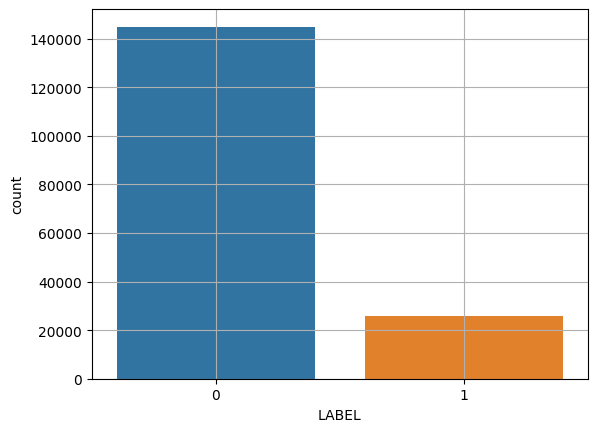

In [26]:
print(data.LABEL.value_counts())
sns.countplot(data, x='LABEL')
plt.grid(True)
plt.show()

Вывод: в данных наблюдается явная несбалансированность в метках и это потребуется учитывать в обучении

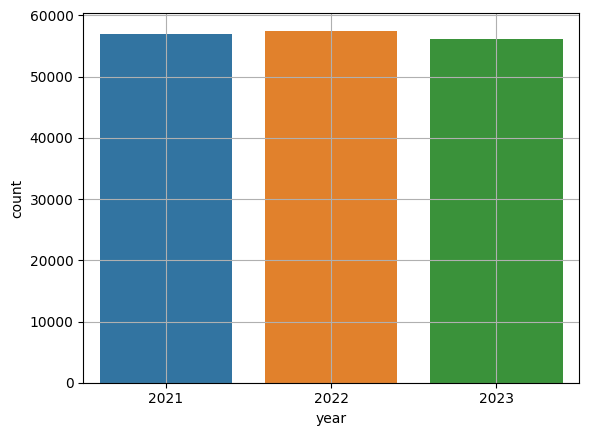

In [27]:
sns.countplot(data, x='year')
plt.grid(True)
plt.show()

Вывод: данные по годам распределены равномерно, значит можно попробовать обучать на 2021 и 2022 году и тестировать на 2023 году

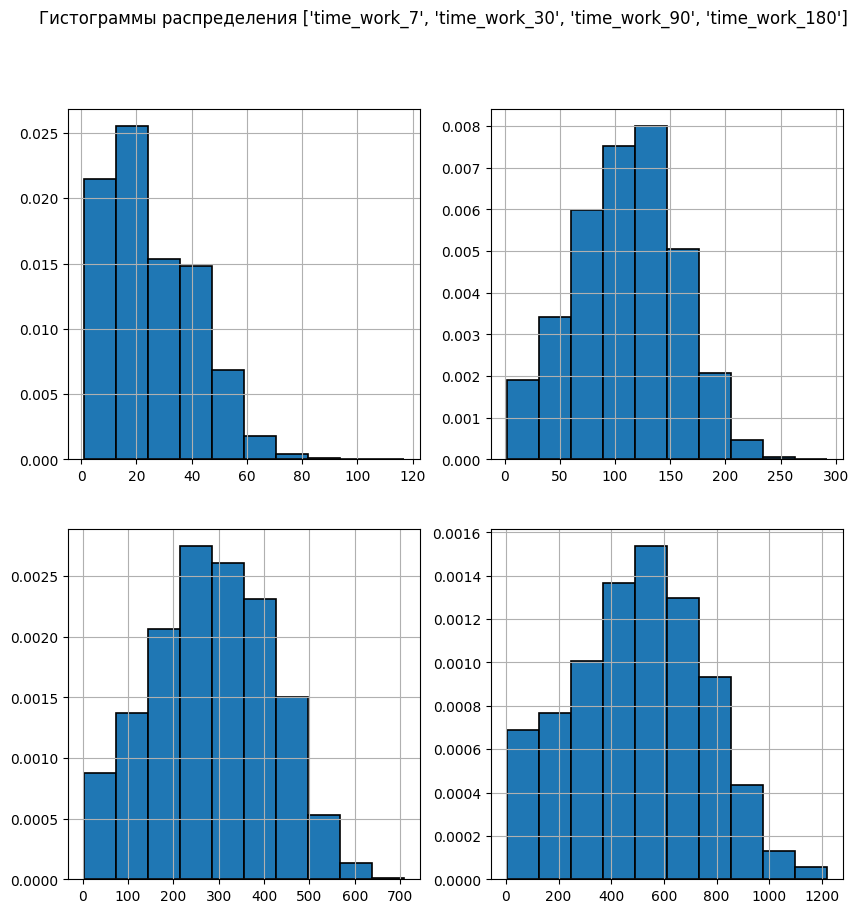

In [28]:
plot_helper.plotHist(data[data.time_work_7 != 0], ["time_work_7", "time_work_30", "time_work_90", "time_work_180"])

Вывод: видно, что в основном данные о времени распределены корректно, так как укладываются в заданный диапазон 7, 30, 90, 180 дней

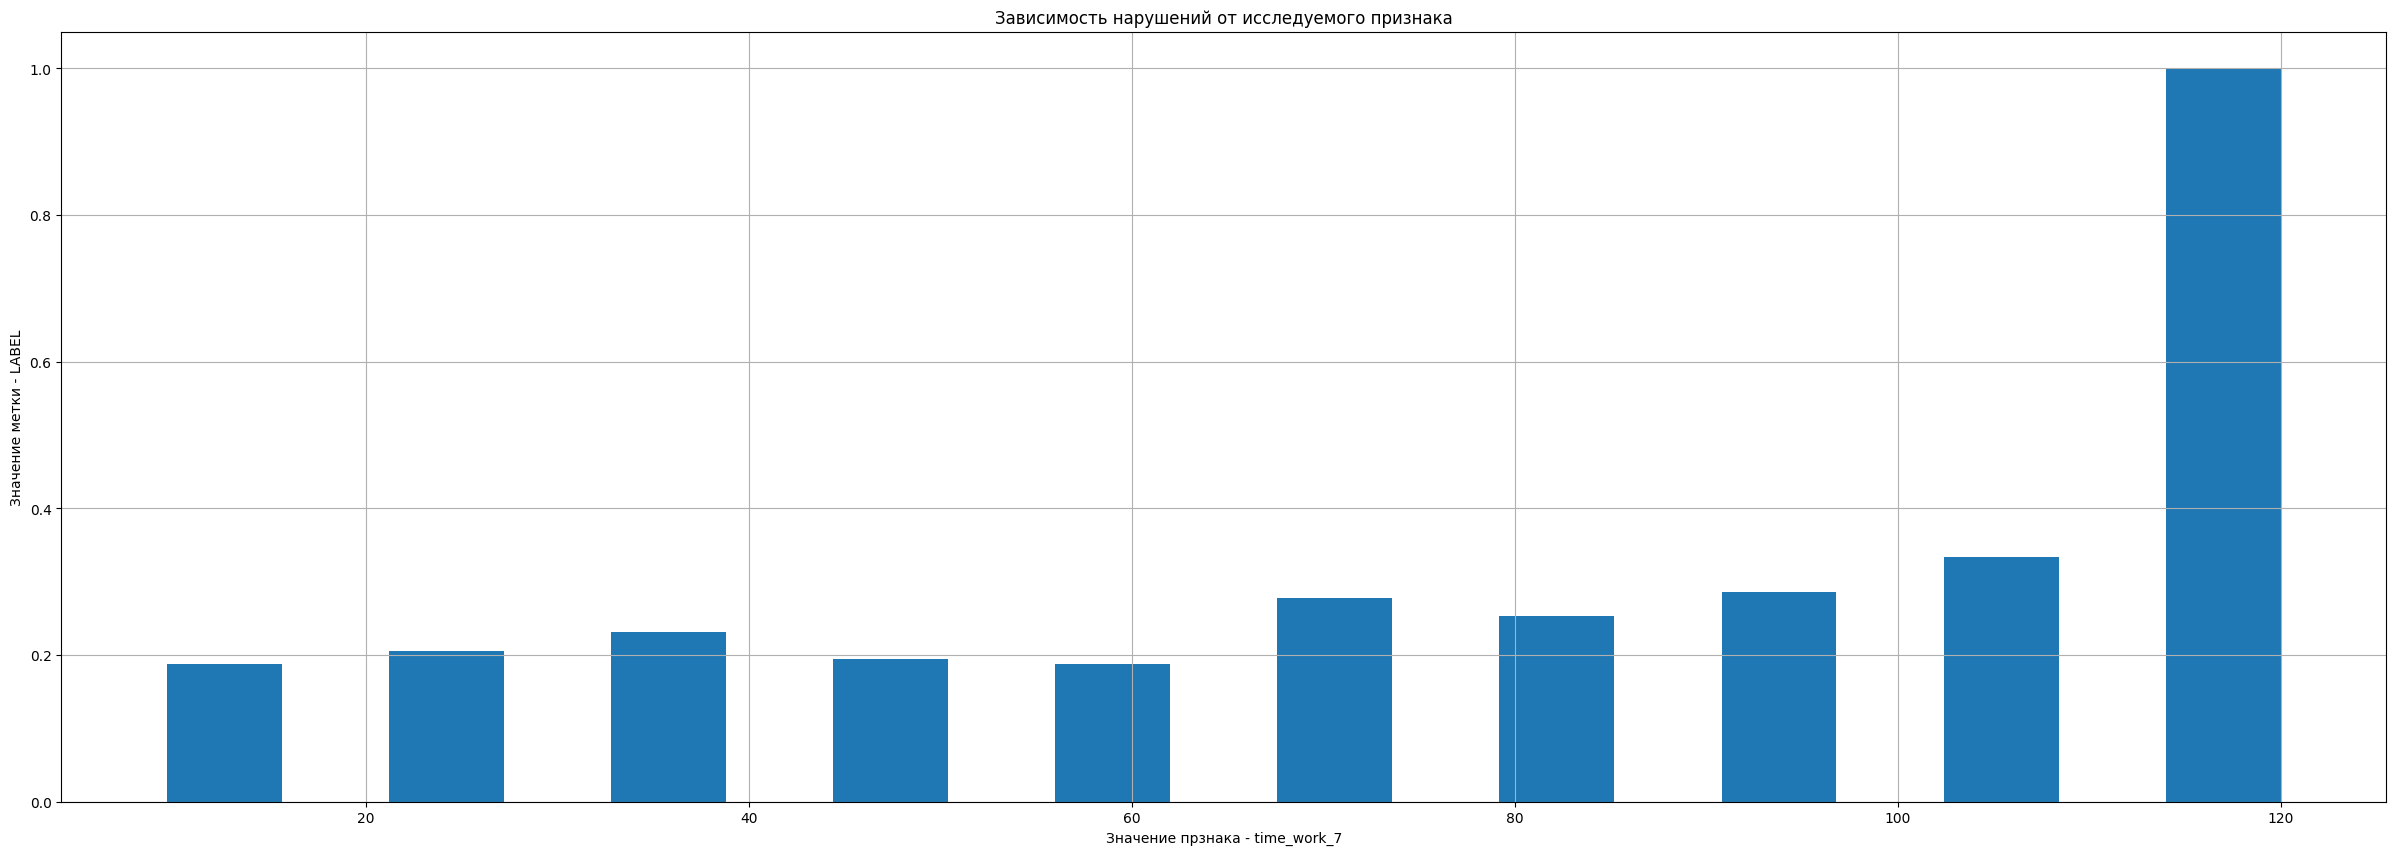

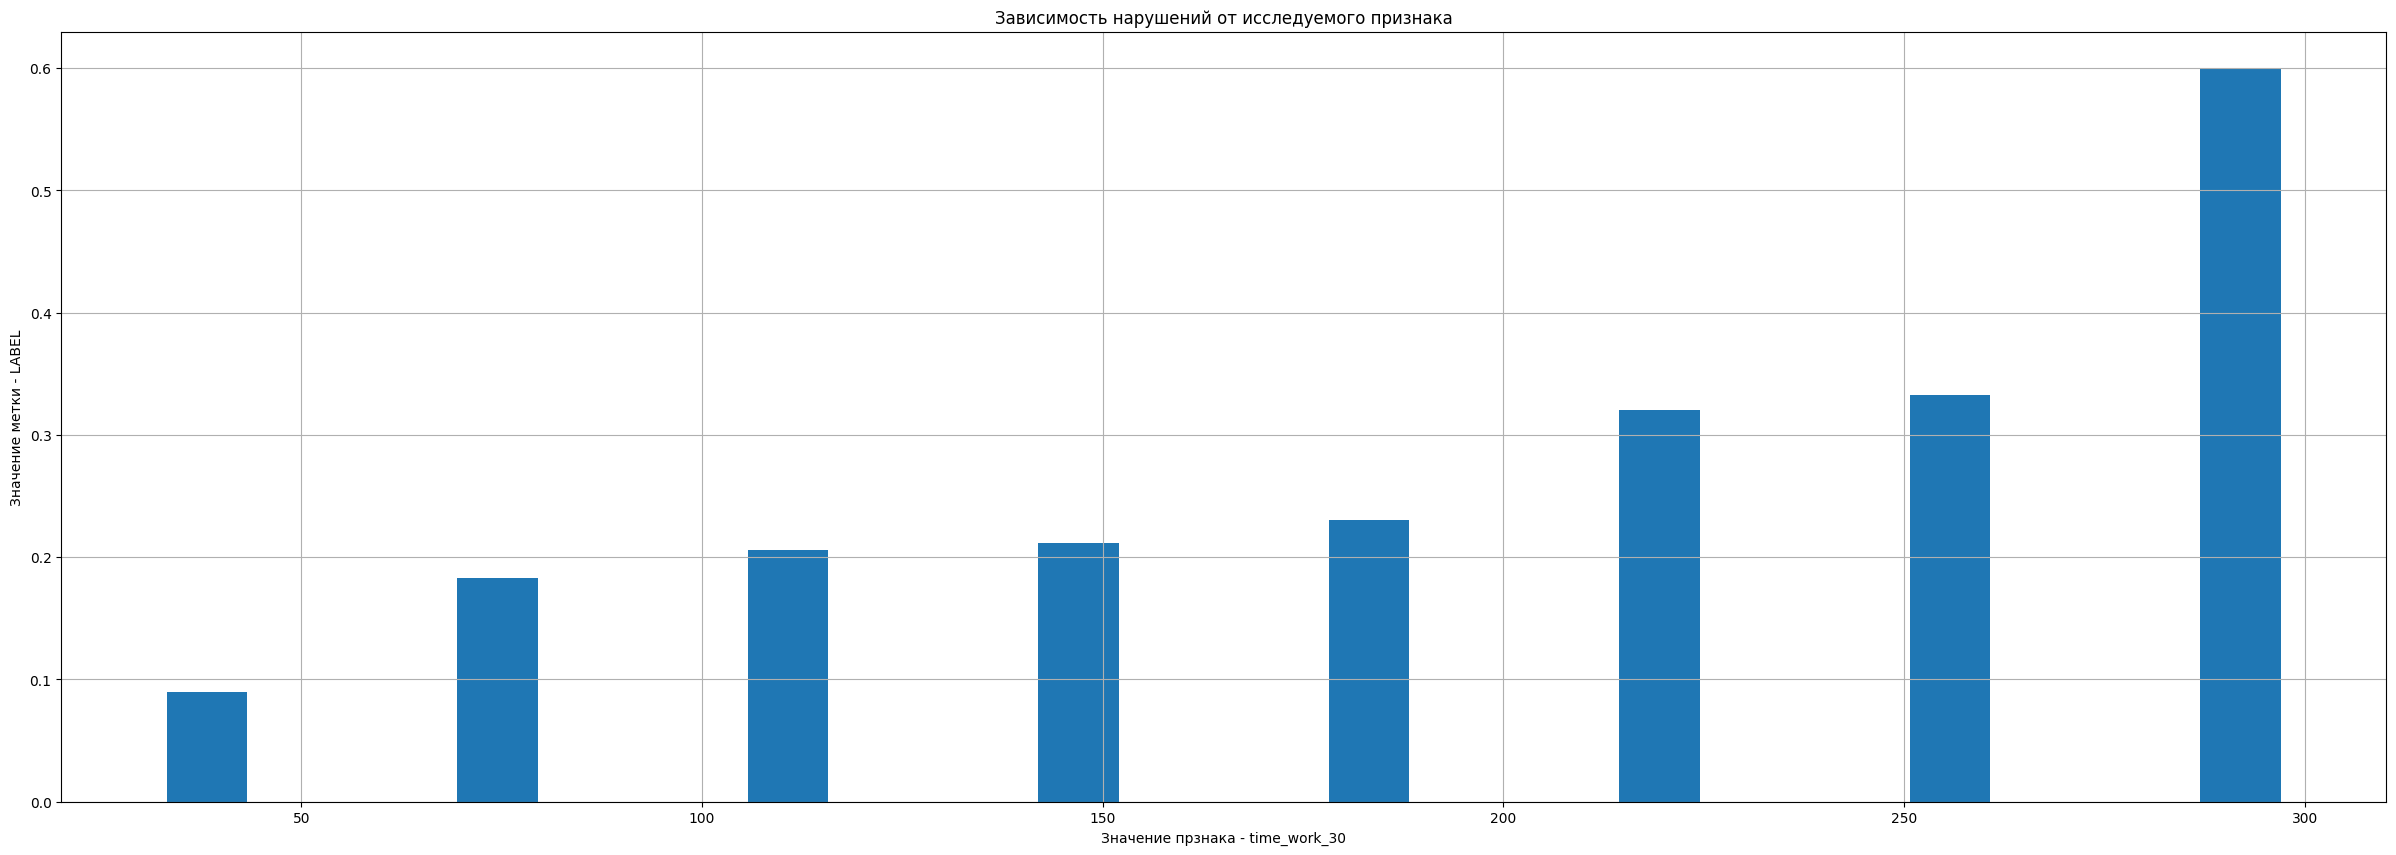

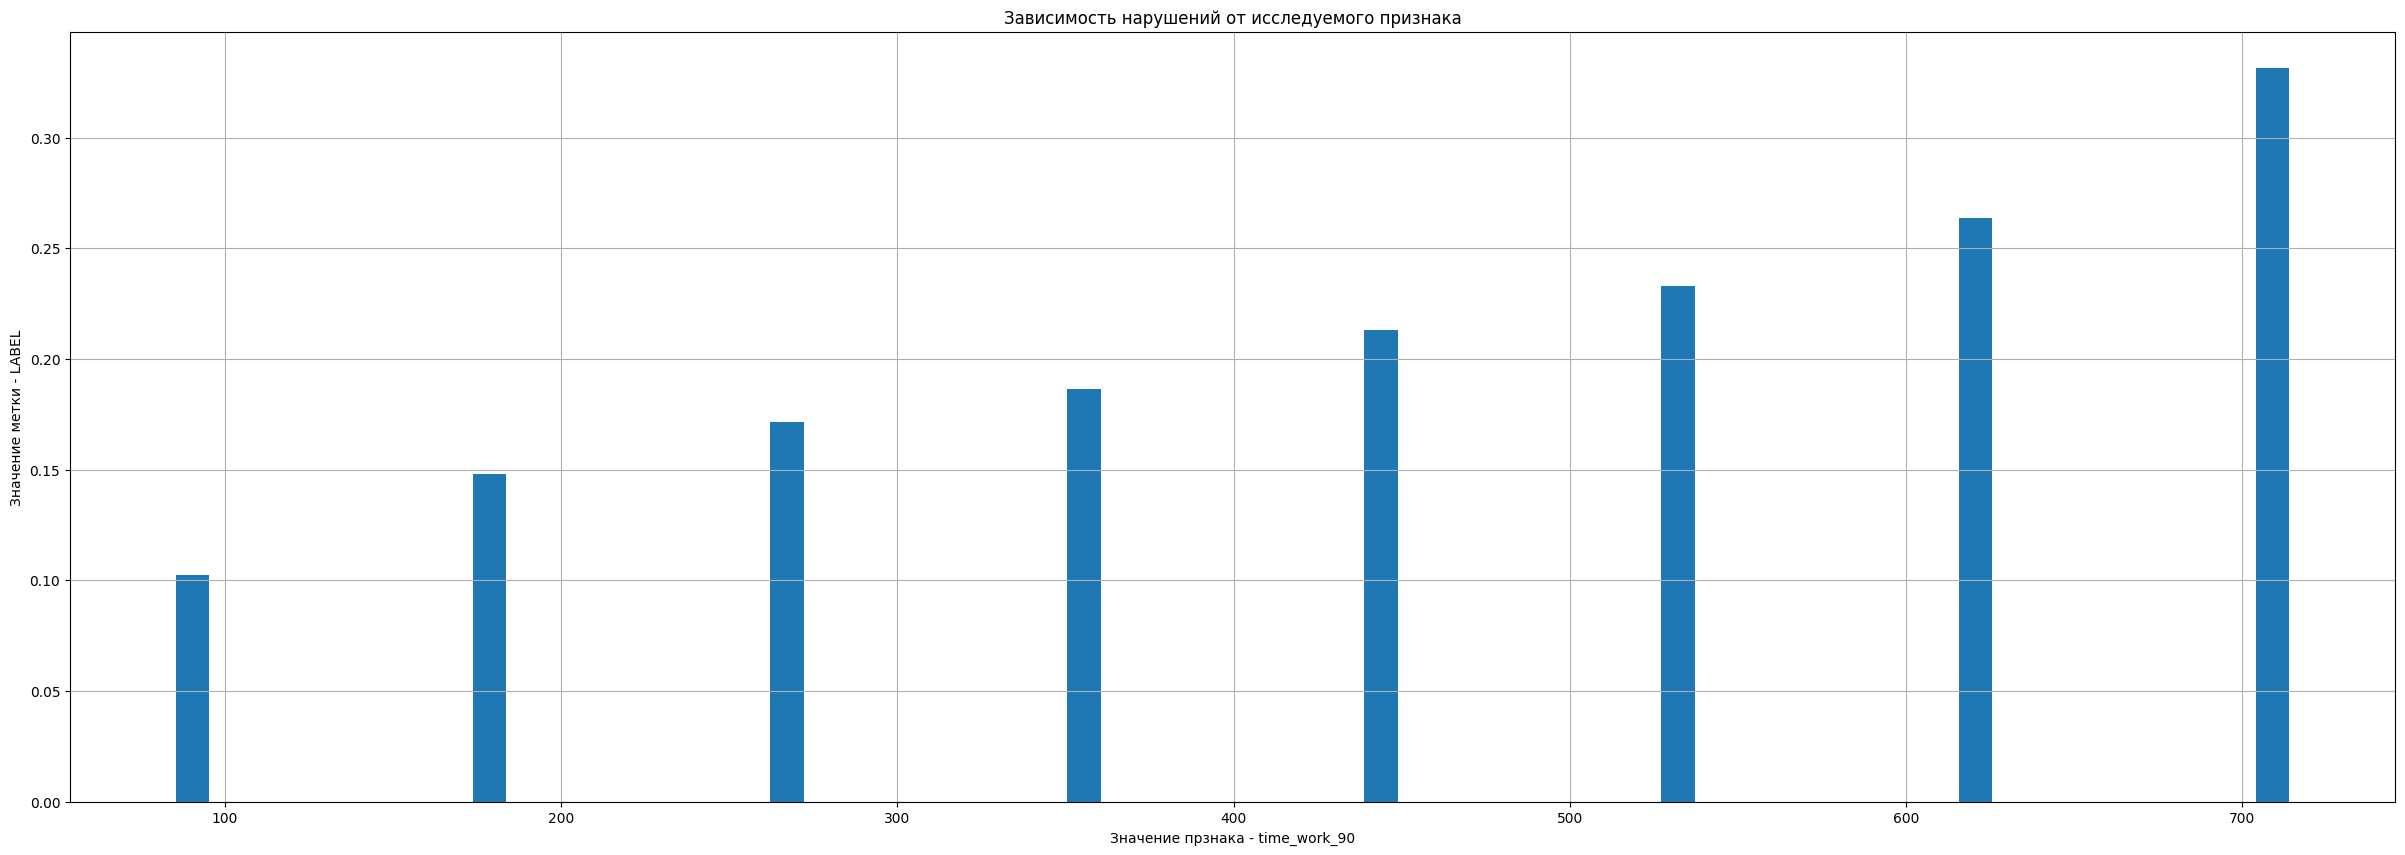

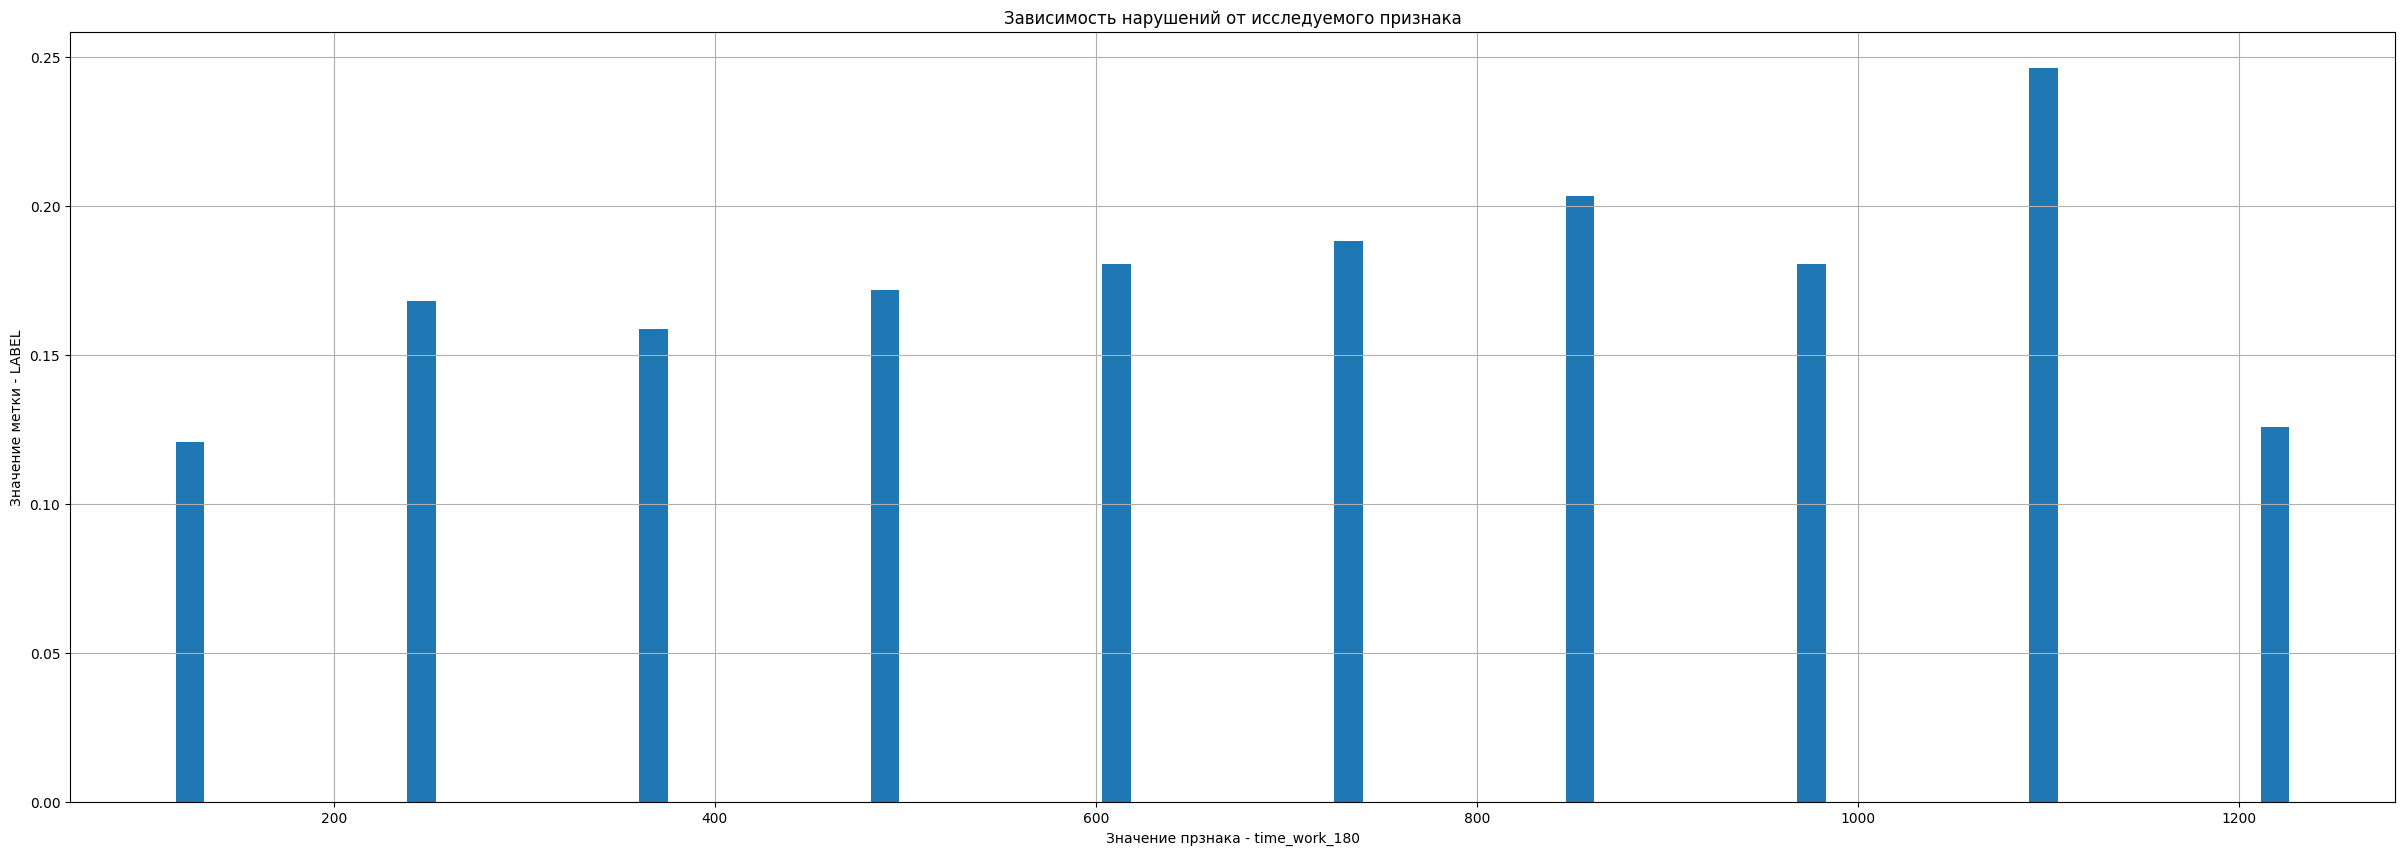

In [29]:
plot_helper.plotsDataDenepnds(data[data.time_work_7 != 0], "time_work_7", "LABEL", num_interval=10, width=6)
plot_helper.plotsDataDenepnds(data[data.time_work_30 != 0], "time_work_30", "LABEL", num_interval=8, width=10)
plot_helper.plotsDataDenepnds(data[data.time_work_90 != 0], "time_work_90", "LABEL", num_interval=8, width=10)
plot_helper.plotsDataDenepnds(data[data.time_work_180 != 0], "time_work_180", "LABEL", num_interval=10, width=15)

Вывод: по графикам видно, что при увеличении количества часов работы увеличивается среднее количество нарушений

Для того, чтобы определить к какой группе статистических критериев отнести оценку данных признаков, проведем оценку на нормальность

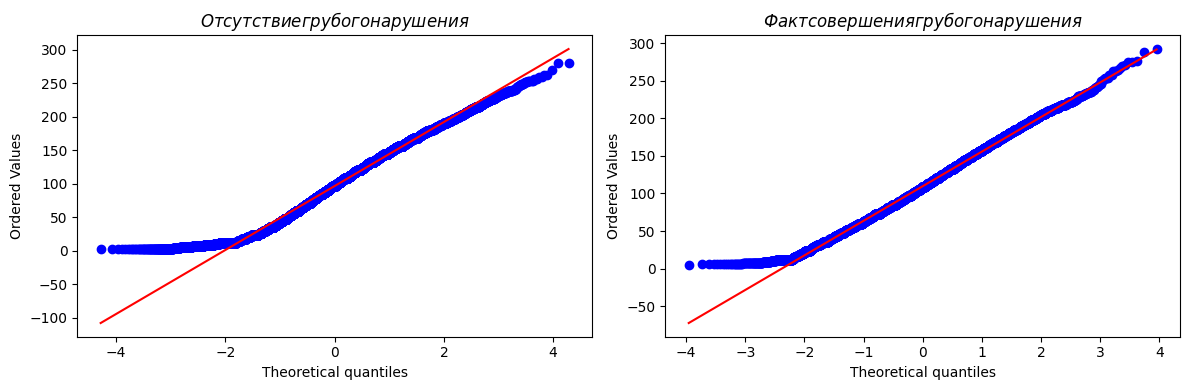

In [31]:
f = "time_work_30"
dataCrewFeatureForAnalysis_true = data[(data["LABEL"] == 1)&(data[f] != 0)]
dataCrewFeatureForAnalysis_false = data[(data["LABEL"] == 0)&(data[f] != 0)]
plot_helper.plot_qq(dataCrewFeatureForAnalysis_false, dataCrewFeatureForAnalysis_true, f)

In [32]:
print("Критерий Шапиро-Уилка", scipy.stats.shapiro(data[data.time_work_180 != 0].time_work_180.iloc[:500]))

Критерий Шапиро-Уилка ShapiroResult(statistic=0.802587628364563, pvalue=3.1829498201425198e-24)


Достигаемый уровень значимости менее 0.05, значит мы можем отвергнуть гипотезу H0 в пользу альтернативы и мы не можем утверждать, что выборка из нормального распрделения

Оценим пересечение доверитеельных интервалов двух выборок (с нарушениями и без нарущений)

In [33]:
def get_bootstrap_samples(data, n_samples):
    random_indeces = np.random.randint(0, len(data), (len(data), n_samples))
    return data[random_indeces]

def getBoundaries(stats, alpha):
    return np.percentile(stats, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

In [34]:
bal_0_stats_scores = list(map(np.mean, 
                               get_bootstrap_samples(dataCrewFeatureForAnalysis_false[f].values, 1000)))
bal_1_stats_scores = list(map(np.mean, 
                               get_bootstrap_samples(dataCrewFeatureForAnalysis_true[f].values, 1000)))

print("Доверительный интервал для LABEL = 0:", 
       getBoundaries(bal_0_stats_scores, 0.05))
print("Доверительный интервал для LABEL = 1:", 
        getBoundaries(bal_1_stats_scores, 0.05))

Доверительный интервал для LABEL = 0: [93.612 99.609]
Доверительный интервал для LABEL = 1: [106.6928 112.392 ]


Вывод: доверительные интервалы не пересекаются, из этого можно допустить, что на уровне значимости 0.05 выборка с нарушениями отличается от выборки без нарушениями.

Данный признак может оказывать влияние на метку.

аналогичную процедру с анализом делаем и с другими признаками, которые планируем использовать для обучения

### 3.5. Разделение данных на обучающую и тестовую выборку

In [36]:
def split_data(data):
    rows = int(data.shape[0]*0.8)
    train_data = data.iloc[:rows]
    test_data = data.iloc[rows:]
    return train_data, test_data


def split_data_by_year(data):
    train_data = data[data.year < 2023]
    test_data = data[data.year == 2023]
    return train_data, test_data


In [37]:
train_data, test_data = split_data_by_year(data)

In [39]:
def get_nan_idx(data):
    list_nan_idx = list()
    for col in data.columns:
        idx = data[col].index[data[col].apply(np.isnan)]
        list_nan_idx += list(idx)
    return list_nan_idx

def get_dataset_for_train(train_data, test_data, label_name):
    X_train = train_data[f_cat + f_num]
    y_train = train_data[label_name]
    X_test = test_data[f_cat + f_num]
    y_test = test_data[label_name]
    # Масштабирование
    scaler = StandardScaler()
    X_train_scl = scaler.fit_transform(X_train[f_num])
    X_test_scl = scaler.transform(X_test[f_num])
    X_train_scl = np.concatenate([X_train[f_cat].astype(int).values, X_train_scl], axis=1)
    X_test_scl = np.concatenate([X_test[f_cat].astype(int).values, X_test_scl], axis=1)
    X_train_scl = pd.DataFrame(X_train_scl)
    X_test_scl = pd.DataFrame(X_test_scl)
    # Удалениние nan
    list_train_nan_idx = get_nan_idx(X_train_scl)
    list_test_nan_idx = get_nan_idx(X_test_scl)
    X_train_scl = X_train_scl[~X_train_scl.index.isin(list_train_nan_idx)]
    y_train = y_train[~y_train.index.isin(list_train_nan_idx)]
    X_test_scl= X_test_scl[~X_test_scl.index.isin(list_test_nan_idx)]
    y_test = y_test[~y_test.index.isin(list_test_nan_idx)]
    # Именование колонок
    X_train_scl.columns =  f_cat + f_num
    X_test_scl.columns = f_cat + f_num
    # Индексирование категориальных признаков
    for col in f_cat:
        X_train_scl[col] = X_train_scl[col].astype(int)
        X_test_scl[col] = X_test_scl[col].astype(int)
    return X_train_scl, X_test_scl, y_train, y_test, scaler

In [40]:
X_train_scl, X_test_scl, y_train_norm, y_test_norm, scaler = get_dataset_for_train(train_data, test_data, label_name)

In [41]:
X_train_scl.shape, X_test_scl.shape

((114525, 101), (56073, 101))

## 4. Обучение модели и оценка качества

### 4.1. Обучение модели

In [47]:
weights = compute_class_weight('balanced', classes=np.unique(y_train_norm), y=y_train_norm)

In [49]:
model = CatBoostClassifier(
    iterations=3000,
    depth=4, 
    learning_rate=0.01, 
    task_type="GPU", 
    devices='0:1',
    loss_function='Logloss', 
    eval_metric='AUC',
    class_weights=weights, 
    od_type="Iter", 
    od_wait=300
)

In [50]:
model.fit(
    X_train_scl, 
    y_train_norm,
    eval_set=(X_test_scl, y_test_norm), 
    cat_features=f_cat, 
    use_best_model=True, 
    plot=True, 
    metric_period=100,
    verbose=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8165739	best: 0.8165739 (0)	total: 45.6ms	remaining: 2m 16s
100:	test: 0.8352578	best: 0.8352578 (100)	total: 1.49s	remaining: 42.8s
200:	test: 0.8421060	best: 0.8421060 (200)	total: 2.81s	remaining: 39.1s
300:	test: 0.8453177	best: 0.8454164 (299)	total: 4.11s	remaining: 36.9s
400:	test: 0.8483776	best: 0.8484349 (364)	total: 5.51s	remaining: 35.7s
500:	test: 0.8496309	best: 0.8498575 (484)	total: 6.98s	remaining: 34.8s
600:	test: 0.8500029	best: 0.8501562 (564)	total: 8.41s	remaining: 33.6s
700:	test: 0.8509074	best: 0.8513579 (681)	total: 9.79s	remaining: 32.1s
800:	test: 0.8503023	best: 0.8513579 (681)	total: 11.3s	remaining: 31s
900:	test: 0.8499737	best: 0.8513579 (681)	total: 12.8s	remaining: 29.8s
bestTest = 0.8513579369
bestIteration = 681
Shrink model to first 682 iterations.


In [51]:
model

### 4.2. Оценка качества

F1 =  0.5147494927423132
Normalized confusion matrix


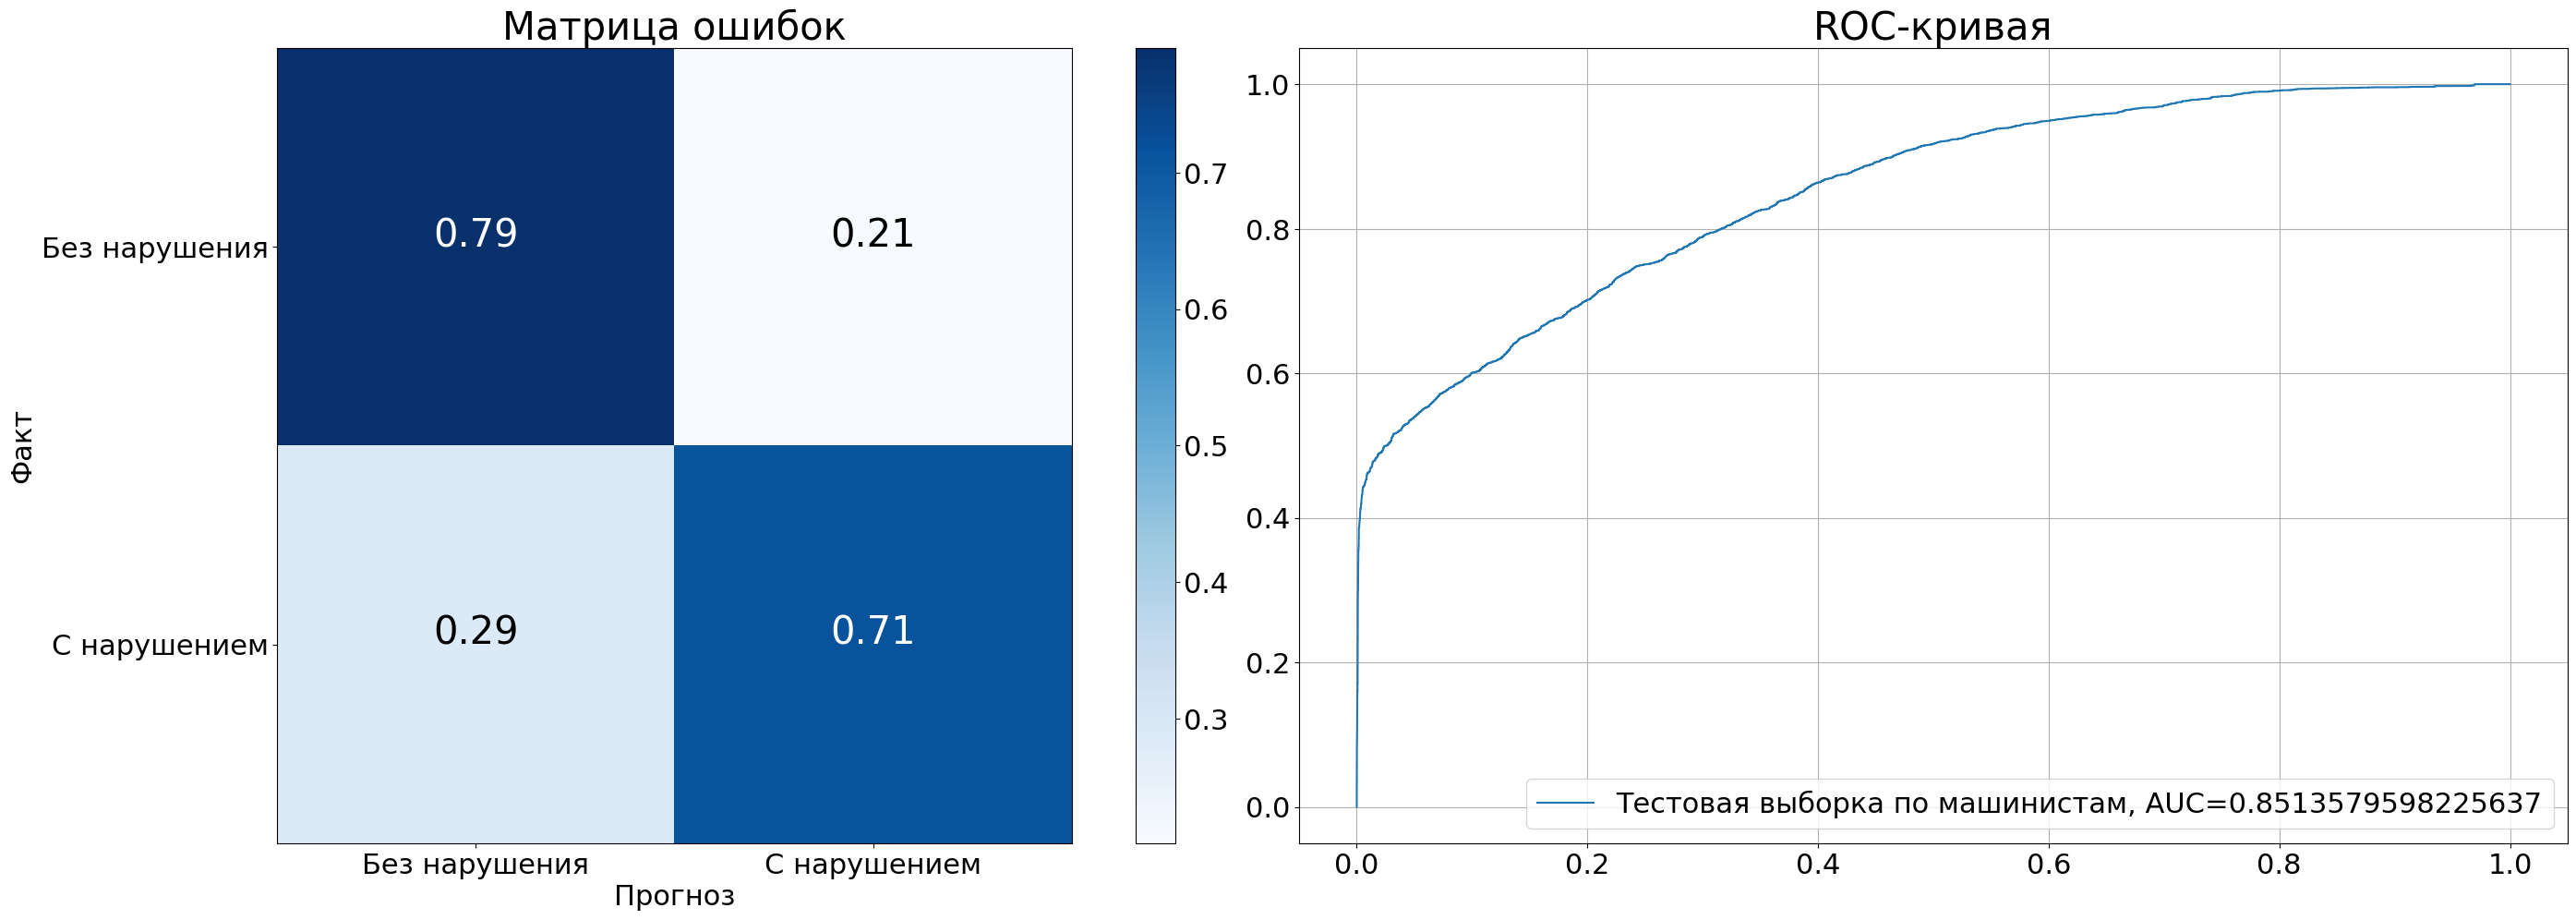

(0.8513579598225637, 0.5147494927423132)

In [52]:
plot_helper.plotTableAUCRoc(model, X_test_scl, y_test_norm, thresholder=0.5, normalize=True)

<Axes: >

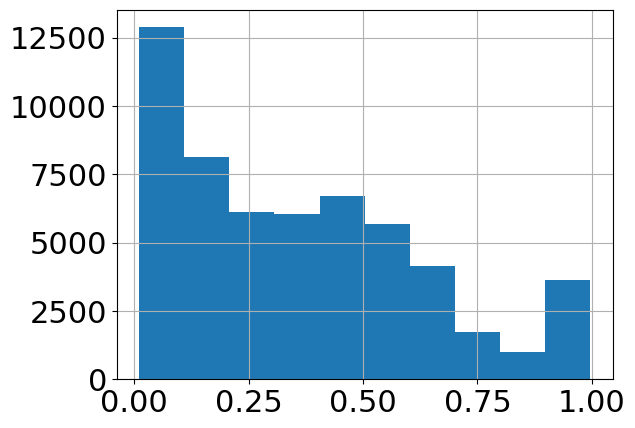

In [53]:
pd.Series(model.predict_proba(X_test_scl)[:, 1]).hist()

Вывод: в результате обучена модель, значение метрики AUC=0.85 на тестовой выборке

### 4.3. Сохранение модели

In [54]:
model

In [55]:
model.save_model("models/test_model")

In [56]:
model_from_file = CatBoostClassifier()
model_from_file.load_model("models/test_model")

In [57]:
model == model_from_file

True

## 5. Инференс модели

In [58]:
X_test_scl["crew"] = test_data.crew.values
X_test_scl["year"] = test_data.year.values
X_test_scl["day"] = test_data.day.values
X_test_scl["date_work"] = test_data.date_work.values

In [59]:
one_crew = X_test_scl[X_test_scl.crew == 61187200].sort_values(by=["date_work"])
one_crew["predict"] = model_from_file.predict_proba(one_crew[f_cat+f_num])[:, 1]
one_crew.index = one_crew.date_work

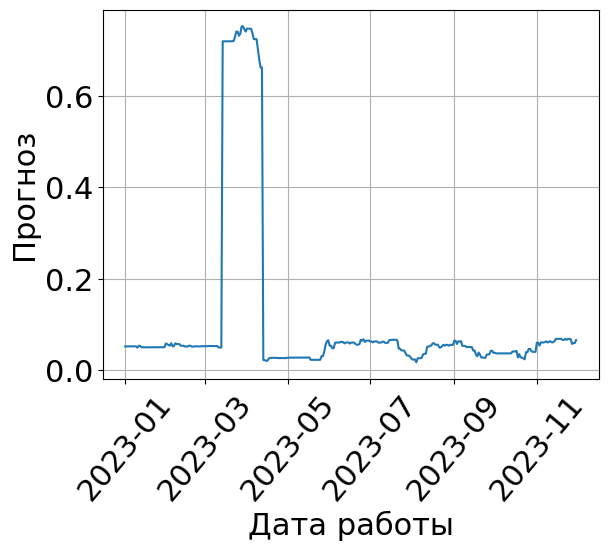

In [60]:
plt.plot(one_crew.predict)
plt.grid(True)
plt.xticks(rotation=50)
plt.xlabel("Дата работы")
plt.ylabel("Прогноз")
plt.show()